### Goal
Implement a neural network model using the individual and gene effect information.

### TODO 
 - 1. Autoencoder for individual effect

### Conclusions
 - 1. For a model with one single layer 95 or 64 nodes does not make any difference. Using Huber-loss insead of mean squared error also does not make any difference. 

In [25]:
import os

import comet_ml
import numpy as np
import pandas as pd

import keras
from keras import backend as K
from keras.layers import *
from keras.models import Sequential

from keras.models import Model
from keras.losses import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import *

import warnings; warnings.simplefilter('ignore')

import rep.preprocessing_new as prep
import rep.datasets as d
import rep.models as m
import rep.metrics as mt

import matplotlib.pyplot as plt
%matplotlib inline
%autoreload 1

from tensorflow.python.client import device_lib
import tensorflow as tf

# import keras
# from keras import backend as K

from numpy.random import seed
seed(1)

# from tensorflow import keras
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import *

# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.losses import *
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.regularizers import *

In [2]:
config = tf.ConfigProto( device_count = {'GPU': 1, 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18180157204057138633
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9763388653158302754
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2737033691413181194
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3254583296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8321024024303550921
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
data_path = os.readlink(os.path.join("..","..","data"))
path = os.path.join(data_path,"processed","gtex")
x_inputs_h5 = os.path.join(path,"X_inputs_pc_onlyblood.h5")
y_targets_h5 = os.path.join(path,"Y_targets_pc_onlyblood.h5")
train_raw, valid_raw = d.rep_blood_expression(x_inputs_h5, y_targets_h5, label=None)

In [6]:
# filter train and valid by tissue
train = train_raw.filter_by(from_tissue='Whole Blood',to_tissue='Muscle - Skeletal')
valid = valid_raw.filter_by(from_tissue='Whole Blood',to_tissue='Muscle - Skeletal')
del train_raw, valid_raw

In [7]:
train.inputs.shape, train.targets.shape, train.metadata.shape, train.features.shape

((220, 19932), (220, 19932), (220, 11), (19932, 3))

In [8]:
# interactive plot of the loss

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    
#     def __init__(self,start_epoch=1):
#         self.start_epoch = start_epoch
    
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
#         print(epoch)
#         if epoch >= self.start_epoch:
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()


### 1. Autoencoder for individual effect
The AE should perform similar to the PCA (idealy even better)<br/>
PCA performance for the individual effect (mean_spearmanr = 0.78, median_spearmanr = 0.93 (ncomp = 95)

Model 1 hidden layer with 95 nodes: mean_spearmanr = 0.77, median_spearmanr = 0.93 <br/>
Model 1 hidden layer with 95 nodes + huber_loss: mean_spearmanr = 0.77, median_spearmanr = 0.93 <br/>
Model 1 hidden layer with 64 nodes: mean_spearmanr = 0.77, median_spearmanr = 0.93 <br/>
Model 1 hidden layer with 32 nodes: mean_spearmanr = 0.77, median_spearmanr = 0.92 <br/>

Adding more layers / Dropout or activation function does not help improving the model

In [1]:
from sklearn.utils.validation import check_array as check_arrays

# loss
def mean_absolute_percentage_error(y_true, y_pred): 
    return K.mean(K.abs((y_true - y_pred) / y_true)) * 100

def huber_loss(y_true, y_pred, clip_delta=1):
    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

    return tf.where(cond, squared_loss, linear_loss)


# optimizer
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0000001)

# autoencoder
code_size = 32
ae = Sequential([   
    Dense(128, input_shape=(train.inputs.shape[1],)),
    Dense(code_size),
    Dense(128),
    Dense(train.inputs.shape[1])
])
ae.compile(optimizer = adam, 
           loss = 'mean_squared_error')
#            loss = huber_loss)


ae.fit(train.inputs,
       train.inputs,
       epochs=500,
       batch_size=16,
       validation_data=(valid.inputs, valid.inputs),
       verbose=0,
       callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10),
                 plot_losses])

recovered_data = ae.predict(valid.inputs)
eval_ae = mt.rep_metric(valid.inputs, recovered_data)

NameError: name 'Adam' is not defined

In [49]:
eval_ae['spearmanr']

{'mean': 0.7748012330096412,
 'min': -0.32335198926422715,
 'p10': 0.2714703348359809,
 'p25': 0.682854766264811,
 'median': 0.9232028716269403,
 'p75': 0.9681769996956242,
 'p90': 0.9802680604972868,
 'max': 0.9939544695991687}

### 3. Neural network - implement gene expression imputation from blood to muscle tissue

#### 3.1 Implement a network with one layer to predict from blood to muscle

In [19]:
hidden = 64
nn = Sequential([
    Dense(hidden, input_shape=(train.inputs.shape[1],)),
    Dense(train.inputs.shape[1])
])
nn.compile(optimizer = adam, 
           loss = 'mean_squared_error')
nn.reset_states()
nn.fit(train.inputs,
       train.targets,
       epochs=500,
       batch_size=16,
       validation_data=(valid.inputs, valid.targets),
       verbose=0,
       callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=5)])
recovered_data = nn.predict(valid.inputs)
eval_nn = mt.rep_metric(valid.targets, recovered_data)
eval_nn['spearmanr']

{'mean': 0.32708409937405153,
 'min': -0.4964952687755446,
 'p10': 0.015261935930561157,
 'p25': 0.16836818324962177,
 'median': 0.34903650372417216,
 'p75': 0.49716618739487645,
 'p90': 0.60299649450203,
 'max': 0.8727828040531936}

#### 3.1.1 Add layers

In [15]:
x_train = train.inputs[:,:10000].reshape(-1,100,100)
y_train = train.targets[:,:10000]
x_valid = valid.inputs[:,:10000].reshape(-1,100,100)
y_valid = valid.targets[:,:10000]

In [76]:
np.random.seed(1337)
# optimizer
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0000001)

def simple_model():
    
    hidden = 1024
    hidden_2 = 256
    hidden_3 = 64
    hidden_4 = 32
    
    nn_aux = Sequential([
        Dense(hidden, input_shape=(train.inputs.shape[1],)),
        Dense(hidden_2),
        Dense(hidden_3),
        Dense(hidden_4),
        Dense(train.inputs.shape[1])
    ])
    nn_aux.compile(optimizer = adam, 
               loss = 'mean_squared_error')

    return nn_aux

In [77]:
nn = simple_model()

In [78]:
nn.reset_states()
nn.fit(train.inputs,
       train.targets,
       epochs=500,
       batch_size=16,
       validation_data=(valid.inputs, valid.targets),
       verbose=0,
       callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5)])
recovered_data = nn.predict(valid.inputs)
eval_nn = mt.rep_metric(valid.targets, recovered_data)
eval_nn['spearmanr']

{'mean': 0.29230391734801814,
 'min': -0.40162066413046044,
 'p10': -0.008554778273798682,
 'p25': 0.12727561228072834,
 'median': 0.30400512187068746,
 'p75': 0.457812926409061,
 'p90': 0.5804582380302498,
 'max': 0.861583996353003}

In [67]:
nn.save("simple_layer_model.h5")

#### 3.2 Network 
- contains the AE hidden layer of the individual variation as first layer

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(1234)

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

hidden = 128
hidden_2 = 64
hidden_3 = 32

x = torch.tensor(train.inputs)
y = torch.tensor(train.targets)
model = nn.Sequential(
                    nn.Linear(train.inputs.shape[1],hidden),
                    nn.Conv1d(hidden,1,3,stride=1),
                    nn.Conv1d(10,10,3,stride=2,dilation=2),
                    nn.Conv1d(10,10,3,stride=4,dilation=4)
#     ,
#                     Flatten(),
#                     nn.Linear(hidden, train.inputs.shape[1])
                    )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.0000001)


for epoch in range(500):
    # Forward Propagation
    y_pred = model(x)
    print(y_pred.shape)
    # Compute and print loss
    loss = criterion(y_pred, y)
    
    if epoch % 50 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

x_valid = torch.tensor(valid.inputs)
y_valid = torch.tensor(valid.targets)

y_pred = model(x_valid)
eval_nn = mt.rep_metric(valid.targets, y_pred.detach().numpy())
eval_nn['spearmanr']

In [9]:
import torch
import pycuda.driver as cuda

cuda.init()

## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name()

In [78]:
train.inputs.shape

(220, 19932)

In [143]:
# x_train = train.inputs[:,:18000].reshape(-1,200,90)
# y_train = train.targets[:,:18000]
# x_valid = valid.inputs[:,:18000].reshape(-1,200,90)
# y_valid = valid.targets[:,:18000]

x_train = train.inputs[:,:18000].reshape(-1,200,90)
y_train = train.targets
x_valid = valid.inputs[:,:18000].reshape(-1,200,90)
y_valid = valid.targets

In [13]:
# optimizer
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.00000001)

def model_conv(input_size1, input_size2):
    
    
    # first submodel
    input1 = keras.layers.Input(shape=(input_size1[0],input_size1[1],1))
        
    hidden3 = keras.layers.Conv2D(7, (3,3), strides=1, padding='valid')(input1)
    hidden3 = keras.layers.Conv2D(7, (3,3), dilation_rate = 2, padding='valid')(hidden3)
#     hidden3 = keras.layers.Conv2D(7, (3,3), dilation_rate = 4, padding='valid')(hidden3)

    flat = keras.layers.Flatten()(hidden3)
    
    outh = keras.layers.Dropout(rate=0.2)(flat)
    outh = keras.layers.Dense(32)(outh)
       
    outh = keras.layers.Dropout(rate=0.2)(outh)
    outh = keras.layers.Dense(64)(outh)
   
    outh = keras.layers.Dropout(rate=0.2)(outh)
    outh1 = keras.layers.Dense(128)(outh)

#     outh1 = keras.layers.Dropout(0.2)(outh)
    
#     outh1 = keras.layers.Dense(input_size[0]*input_size[1])(outh)
    
#     nn_aux = keras.models.Model(inputs=input1, outputs=outh)
#     nn_aux.compile(optimizer = adam, 
#                loss = 'mean_squared_error')

    
    # second submodel
    input2 = keras.layers.Input(shape=(input_size2,))
    print(input2.shape)
    outh2 = keras.layers.Dense(64)(input2)
    outh2 = keras.layers.Dropout(rate=0.25)(outh2)
    outh2 = keras.layers.Dense(32)(outh2)
    outh2 = keras.layers.Dropout(rate=0.25)(outh2)


    print(outh2.shape)
#     outh1 = keras.layers.Reshape(target_shape=(1,128))(outh1)
#     outh2 = keras.layers.Reshape(target_shape=(1,32))(outh2)
#     concat = keras.layers.concatenate([outh1, outh2])
#     print(concat.shape)
#     concat = K.squeeze(concat,axis=1)
#     print(concat.shape)
#     outh3 = keras.layers.Dense(input_size[0]*input_size[1])(concat)
#     print(outh3.shape)
#     print(input1.shape)
#     print(input2.shape)
#     print(outh3.shape)
    outh3 = keras.layers.Dense(input_size2)(outh2)
    print(outh3.shape)
    nn_aux = keras.models.Model(inputs=[input1,input2], outputs=[outh3])
    nn_aux.compile(optimizer = adam, 
               loss = 'mean_squared_error')

    
    
    return nn_aux

In [144]:
nn = model_conv((x_train.shape[1],x_train.shape[2]), train.inputs.shape[1])
nn.reset_states()
nn.fit(x=[K.expand_dims(x_train),train.inputs],
       y=y_train,
       epochs=500,
#        batch_size=16,
       steps_per_epoch=16,
       validation_steps=1,
       validation_data=([K.expand_dims(x_valid),valid.inputs], y_valid),
       verbose=0,
       callbacks=[
           EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10)
           , 
           plot_losses
       ])

TypeError: model_conv() takes 1 positional argument but 2 were given

In [64]:
y_pred = nn.predict([K.expand_dims(x_valid),valid.inputs],steps=1)
eval_nn = mt.rep_metric(y_valid, y_pred)
eval_nn['spearmanr']

{'mean': 0.3637025457788201,
 'min': -0.4228279308306054,
 'p10': 0.06465575036333858,
 'p25': 0.223556140680859,
 'median': 0.3907617708395499,
 'p75': 0.5231454270948735,
 'p90': 0.6130932639561851,
 'max': 0.8423455572579237}

In [113]:
# optimizer
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0000001)

def model_conv(input_size_):
    
#     code_size = 64
#     inputLength = 64
#     baseNetwork = Sequential()
# #     baseNetwork.add(Dense(code_size))
#     baseNetwork.add(Embedding(input_dim=100, output_dim=80, input_length=input_size_))
#     baseNetwork.add(Conv1D(10, 20, strides=1, padding='valid'))
#     baseNetwork.add(LeakyReLU(0.5))
#     baseNetwork.add(Dropout(0.1))

#     baseNetwork.add(Conv1D(10, 20, dilation_rate=2, padding='valid'))
#     baseNetwork.add(LeakyReLU(0.5))
#     baseNetwork.add(Dropout(0.1))

#     baseNetwork.add(Conv1D(10, 20, dilation_rate=4, padding='valid'))
#     baseNetwork.add(LeakyReLU(0.5))
#     baseNetwork.add(Dropout(0.1))

#     baseNetwork.add(Flatten())

#     baseNetwork.add(Dense(128))
# #     baseNetwork.add(Dropout(0.1))
#     baseNetwork.add(Dense(code_size))
#     baseNetwork.add(Dense(code_size))
# #     baseNetwork.add(Dropout(0.1))
#     baseNetwork.add(Dense(32))
#     baseNetwork.add(Dropout(0.1))
# #     baseNetwork.add(Dense(16))
# #     baseNetwork.add(Dense(16))
# #     baseNetwork.add(Dropout(0.1))
#     baseNetwork.add(Dense(input_size_))

    
    input1 = keras.layers.Input(shape=(input_size_,))
#     emb = keras.layers.Embedding(100, 10, input_length=input_size_)(input1)
#     h = keras.layers.Conv1D(2, 5, strides=1, padding='valid')(emb)
#     h = keras.layers.AveragePooling1D()(h)
#     h = keras.layers.Conv1D(2, 5, dilation_rate=2, padding='valid')(h)
#     h = keras.layers.AveragePooling1D()(h)
#     h = keras.layers.Conv1D(2, 5, dilation_rate=4, padding='valid')(h)
# #     h = keras.layers.AveragePooling1D()(h)
#     h = keras.layers.Conv1D(2, 5, dilation_rate=16, padding='valid')(h)
#     h = keras.layers.AveragePooling1D()(h)
#     h = keras.layers.Conv1D(3, 5, dilation_rate=32, padding='valid')(h)
#     h0 = keras.layers.AveragePooling1D()(h)
#     flat = keras.layers.Flatten()(h)
    
#     h1 = keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.005))(input1)
#     h2 = keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.005))(h1)
#     h3 = keras.layers.Dense(32, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.005))(h2)
#     h4 = keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.005))(h3)    
#     h5 = keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.005))(h4)
    
    
    h1 = keras.layers.Dense(128)(input1)
    h = keras.layers.Dense(64)(h1)
    h = keras.layers.Dense(32)(h)
    h = keras.layers.Dense(64)(h)    
    h5 = keras.layers.Dense(128)(h)    
    h6 =  Add()([h5, h1])
    out1 = Dropout(0.1)(h5)
    
    
#     h1 = keras.layers.Dense(64)(input1)
#     h = keras.layers.Dense(32)(h1)
#     h = keras.layers.Dense(64)(h)
#     out1 = Dropout(0.1)(h)
    out2 = keras.layers.Dense(input_size_)(out1)
    
    baseNetwork = keras.models.Model(inputs=[input1], outputs=[out2])
    baseNetwork.compile(optimizer = adam, 
               loss = 'mean_squared_error')
   
    
    return baseNetwork

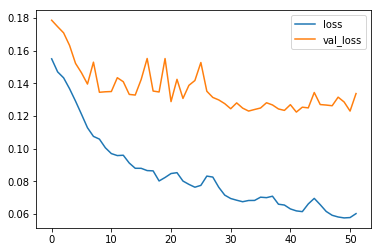

{'mean': 0.37620974505042015,
 'min': -0.3169373663369354,
 'p10': 0.11251903196238353,
 'p25': 0.26479012876865093,
 'median': 0.40086378809487655,
 'p75': 0.5109626566750083,
 'p90': 0.595165725593771,
 'max': 0.8369298264488343}

In [114]:
nn = model_conv(train.inputs[:,:10000].shape[1])
nn.reset_states()
nn.fit(train.inputs[:,:10000],
       train.targets[:,:10000],
       epochs=500,
       batch_size=16,
#        steps_per_epoch=16,
#        validation_steps=1,
       validation_data=(valid.inputs[:,:10000], valid.targets[:,:10000]),
       verbose=0,
       callbacks=[
           EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10), 
           plot_losses
       ])
y_pred = nn.predict(valid.inputs[:,:10000])
eval_nn = mt.rep_metric(valid.targets[:,:10000], y_pred)
eval_nn['spearmanr']

In [98]:
# hidden = 256
# hidden_2 = 128
# hidden_3 = 32
# hidden_4 = 16
# # hidden_2 = 1024
# nn = Sequential([
#     Dense(code_size, input_shape=(train.inputs.shape[1],), trainable=False),
#     Dense(hidden_2),
#     Dense(hidden_3),
#     Dense(hidden_4),
#     Dense(train.inputs.shape[1])
# ])
    
    
#     Dropout(0.1),
#     Dense(hidden_2),
#     Dropout(0.1),
#     Conv1D(filters=16, kernel_size=(3), activation='relu', input_shape=(hidden_2,1)),
#     MaxPooling1D(pool_size=2),
#     Flatten(),
#     Dense(train.inputs.shape[1])
# ])

In [ ]:
print(nn.summary())

In [21]:
?keras.layers.convolutional.Convolution1D

Init signature:
keras.layers.convolutional.Convolution1D(
    filters,
    kernel_size,
    strides=1,
    padding='valid',
    data_format='channels_last',
    dilation_rate=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs,
)
Docstring:     
1D convolution layer (e.g. temporal convolution).

This layer creates a convolution kernel that is convolved
with the layer input over a single spatial (or temporal) dimension
to produce a tensor of outputs.
If `use_bias` is True, a bias vector is created and added to the outputs.
Finally, if `activation` is not `None`,
it is applied to the outputs as well.

When using this layer as the first layer in a model,
provide an `input_shape` argument
(tuple of integers or `None`, e.g.
`(10, 128)` for sequences of 10 vectors of 128-dimensio